In [37]:
import io
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset, DataLoader, RandomSampler, SequentialSampler
)
# from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import (
    AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
)


In [38]:
# Set appropriate device.
DEVICE = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available() 
    else 'cpu'
)

# Set max sequence length (max number of tokens).
MAX_LEN = 128 # 512 used by paper.

# Batch size and epochs for fine-tuning.
BATCH_SIZE = 32
EPOCHS = 2

# TODO: Remove. Only for debugging.
MAX_BATCHES = 200 # Cutoff before proceeding to next step. Default 'None' for full run.


In [39]:
# Load training data.
data_dir = '/Users/justinsima/dir/datasets/CoLA/raw'
data_train = pd.read_csv(
    os.path.join(data_dir, 'in_domain_train.tsv'),
    names=['source', 'label', 'notes', 'sentence'],
    delimiter='\t',
    header=None
)

data_train.head()

,source,label,notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [40]:
# Prepare sentences and labels for BERT.
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in data_train['sentence'].values]
labels = data_train['label'].values

# Tokenize sentences.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]


In [41]:
# Convert tokens to index in BERT vocabulary.
unpadded_sentence_ids = [tokenizer.convert_tokens_to_ids(s) for s in tokenized_sentences]

# Pad sequences and create attention masks.
sentence_ids = np.array([np.pad(np.array(x).flatten(),
                    pad_width =(0, MAX_LEN-len(x)),
                    mode='constant',
                    constant_values=0.
                ) for x in unpadded_sentence_ids])
attention_masks = np.array([
    np.concatenate(
        [np.ones(shape=(len(x))), np.zeros(shape=(MAX_LEN - len(x)))]
    ) for x in unpadded_sentence_ids
])


In [42]:
# Separate training and validation sets.
train_features, val_features, train_labels, val_labels, train_masks, val_masks = train_test_split(
    sentence_ids,
    labels,
    attention_masks,
    test_size=0.1
)


In [43]:
# Convert to pytorch arrays.
train_features = torch.from_numpy(train_features).long()
val_features = torch.from_numpy(val_features).long()
train_labels = torch.from_numpy(train_labels).long()
val_labels = torch.from_numpy(val_labels).long()
train_masks = torch.from_numpy(train_masks).long()
val_masks = torch.from_numpy(val_masks).long()


In [44]:
# Create data loaders.
dataset_train = TensorDataset(train_features, train_masks, train_labels)
train_sampler = RandomSampler(dataset_train)
train_loader = DataLoader(dataset=dataset_train, sampler=train_sampler, batch_size=BATCH_SIZE)

dataset_val = TensorDataset(val_features, val_masks, val_labels)
val_sampler = RandomSampler(dataset_val)
val_loader = DataLoader(dataset=dataset_val, sampler=val_sampler, batch_size=BATCH_SIZE)


In [45]:
# Configure BERT model.
base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = nn.DataParallel(base_model)
model.to(DEVICE)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

In [46]:
# Prepare parameters for training.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.1
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0
    }
]

In [47]:
# Optimizer and scaler.
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr = 1e-5,
    eps = 1e-8
)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0,
    num_training_steps = total_steps
)


/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
# Calculate accuracy.
def accuracy_score(preds, labels):
    class_preds = np.argmax(preds, axis=1).flatten()
    class_labels = labels.flatten()
    return np.sum(class_preds == class_labels) / len(class_labels)

In [49]:
# Training loop.
loss_train_list = []
loss_val_list = []

for epoch in trange(EPOCHS, leave=True, desc='Epoch:'):
    model.train()
    
    # Initialize epoch tracking variables.
    time_start = datetime.datetime.now()
    loss_train, accuracy_train = 0.0, 0.0
    nb_tr_examples, nb_tr_steps = 0, 0
    val_loss, val_accuracy = 0, 0
    n_val_steps, b_val_examples = 0, 0
    
    for step, batch in tqdm(enumerate(train_loader), leave=True, desc='Batches:'):
        # Store tensors and move to device.
        batch_sequences, batch_masks, batch_labels = batch[0].to(DEVICE), batch[1].to(DEVICE), batch[2].to(DEVICE)
        
        optimizer.zero_grad()
        
        # Feed model and calculate loss / accuracy.
        outputs = model(batch_sequences, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs['loss']
        loss_train_list.append(loss.item())
        logits = outputs['logits'].detach().cpu().numpy()
        np_labels = batch_labels.to('cpu').numpy()
        batch_train_accuracy = accuracy_score(logits, np_labels)
        accuracy_train += batch_train_accuracy
        
        # Backwards step.
        loss.backward()
        optimizer.step()
        scheduler.step()
            
        # Update train tracking statistics.
        loss_train += loss.item()
        nb_tr_examples += batch_sequences.size(0)
        nb_tr_steps += 1
        
        # TODO: Remove. Only for debugging.
        if MAX_BATCHES:
            if nb_tr_steps == MAX_BATCHES:
                break

    time_elapsed = datetime.datetime.now() - time_start
                        
    # Evaluate each epoch.
    model.eval()
                        
    for batch in val_loader:
        batch_sequences, batch_masks, batch_labels = batch[0].to(DEVICE), batch[1].to(DEVICE), batch[2].to(DEVICE)
                        
        with torch.no_grad():
            output = model(batch_sequences, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
            logits = output['logits'].detach().cpu().numpy()
            np_labels = batch_labels.to('cpu').numpy()
            
            batch_val_accuracy = accuracy_score(logits, np_labels)
            batch_val_loss = output['loss']
            loss_val_list.append(batch_val_loss.item())
            val_loss += batch_val_loss.item()
            val_accuracy += batch_val_accuracy
            n_val_steps += 1
            
            # TODO: Remove. Only for debugging.
            if MAX_BATCHES:
                if n_val_steps == MAX_BATCHES:
                    break
     
    print(f'Epoch: {epoch}, \
        Average Time per Batch: {time_elapsed / len(train_loader)}, \
        Training Loss: {loss_train / len(train_loader)} \
        Training Accuracy: {accuracy_train / len(train_loader)} \
        Validation Loss: {val_loss / len(val_loader)} \
        Validation Accuracy: {val_accuracy / len(val_loader)}')


Epoch::   0%|                                             | 0/2 [00:00<?, ?it/s]
Batches:: 0it [00:00, ?it/s]
Batches:: 1it [00:08,  8.40s/it]
Batches:: 2it [00:20, 10.39s/it]
Batches:: 3it [00:33, 11.76s/it]
Batches:: 4it [00:45, 11.71s/it]
Batches:: 5it [00:57, 11.88s/it]
Batches:: 6it [01:09, 11.94s/it]
Batches:: 7it [01:21, 12.06s/it]
Batches:: 8it [01:34, 12.28s/it]
Batches:: 9it [01:49, 13.05s/it]
Batches:: 10it [02:04, 13.75s/it]
Batches:: 11it [02:18, 13.82s/it]
Batches:: 12it [02:32, 13.90s/it]
Batches:: 13it [02:46, 13.87s/it]
Batches:: 14it [03:00, 13.85s/it]
Batches:: 15it [03:15, 14.18s/it]
Batches:: 16it [03:28, 14.05s/it]
Batches:: 17it [03:43, 14.14s/it]
Batches:: 18it [03:56, 13.79s/it]
Batches:: 19it [04:09, 13.75s/it]
Batches:: 20it [04:23, 13.84s/it]
Batches:: 21it [04:38, 13.97s/it]
Batches:: 22it [04:52, 13.96s/it]
Batches:: 23it [05:06, 14.04s/it]
Batches:: 24it [05:20, 13.99s/it]
Batches:: 25it [05:34, 14.03s/it]
Batches:: 26it [05:48, 13.97s/it]
Batches:: 27it 

Epoch: 0,         Average Time per Batch: 0:00:11.178792,         Training Loss: 0.4410629920445043         Training Accuracy: 0.6165715767634855         Validation Loss: 0.4389760422485846         Validation Accuracy: 0.8051697530864197



Batches:: 0it [00:00, ?it/s]
Batches:: 1it [00:14, 14.01s/it]
Batches:: 2it [00:27, 13.96s/it]
Batches:: 3it [00:41, 13.95s/it]
Batches:: 4it [00:56, 14.21s/it]
Batches:: 5it [01:10, 14.17s/it]
Batches:: 6it [01:25, 14.57s/it]
Batches:: 7it [01:41, 14.94s/it]
Batches:: 8it [01:56, 14.88s/it]
Batches:: 9it [02:11, 14.84s/it]
Batches:: 10it [02:25, 14.66s/it]
Batches:: 11it [02:39, 14.52s/it]
Batches:: 12it [02:53, 14.43s/it]
Batches:: 13it [03:07, 14.22s/it]
Batches:: 14it [03:19, 13.41s/it]
Batches:: 15it [03:31, 13.02s/it]
Batches:: 16it [03:43, 12.67s/it]
Batches:: 17it [03:54, 12.40s/it]
Batches:: 18it [04:07, 12.35s/it]
Batches:: 19it [04:19, 12.34s/it]
Batches:: 20it [04:31, 12.35s/it]
Batches:: 21it [04:44, 12.42s/it]
Batches:: 22it [04:56, 12.35s/it]
Batches:: 23it [05:09, 12.67s/it]
Batches:: 24it [05:25, 13.56s/it]
Batches:: 25it [05:40, 13.92s/it]
Batches:: 26it [05:54, 14.02s/it]
Batches:: 27it [06:08, 13.93s/it]
Batches:: 28it [06:23, 14.38s/it]
Batches:: 29it [06:37, 14.3

Epoch: 1,         Average Time per Batch: 0:00:11.547106,         Training Loss: 0.3383379464203886         Training Accuracy: 0.6834802904564315         Validation Loss: 0.4267125129699707         Validation Accuracy: 0.8132716049382716


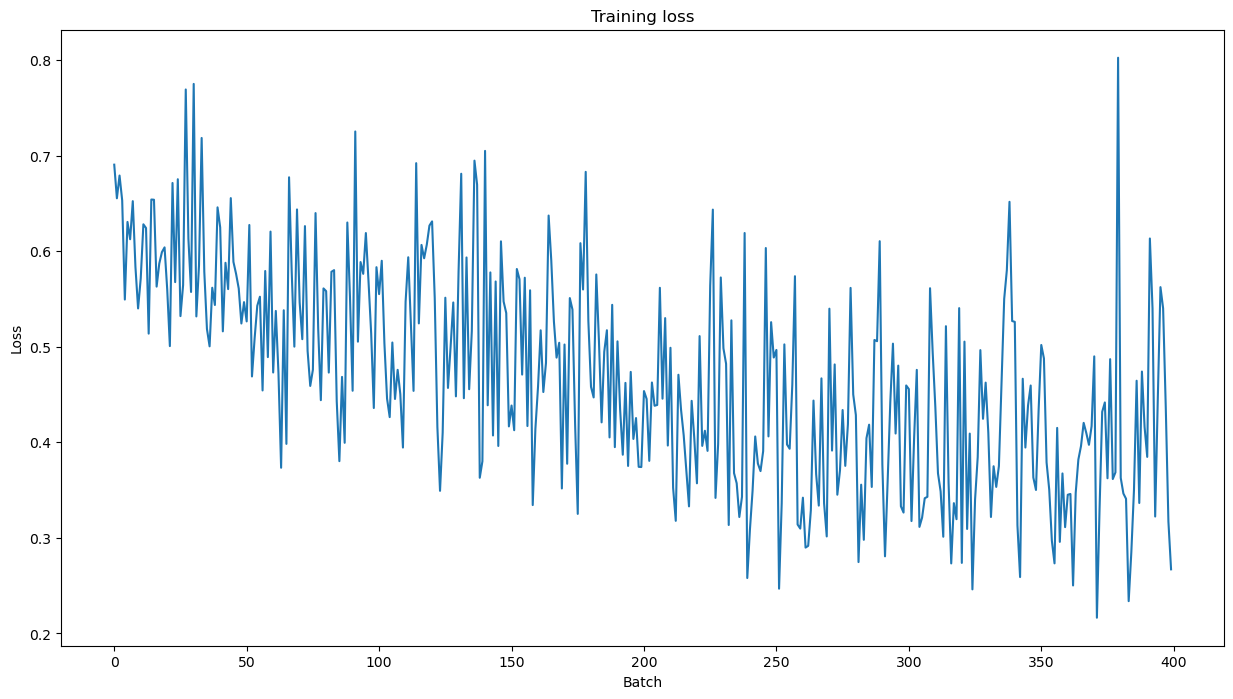

In [50]:
# Visualize training loss.
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(loss_train_list)
plt.show()


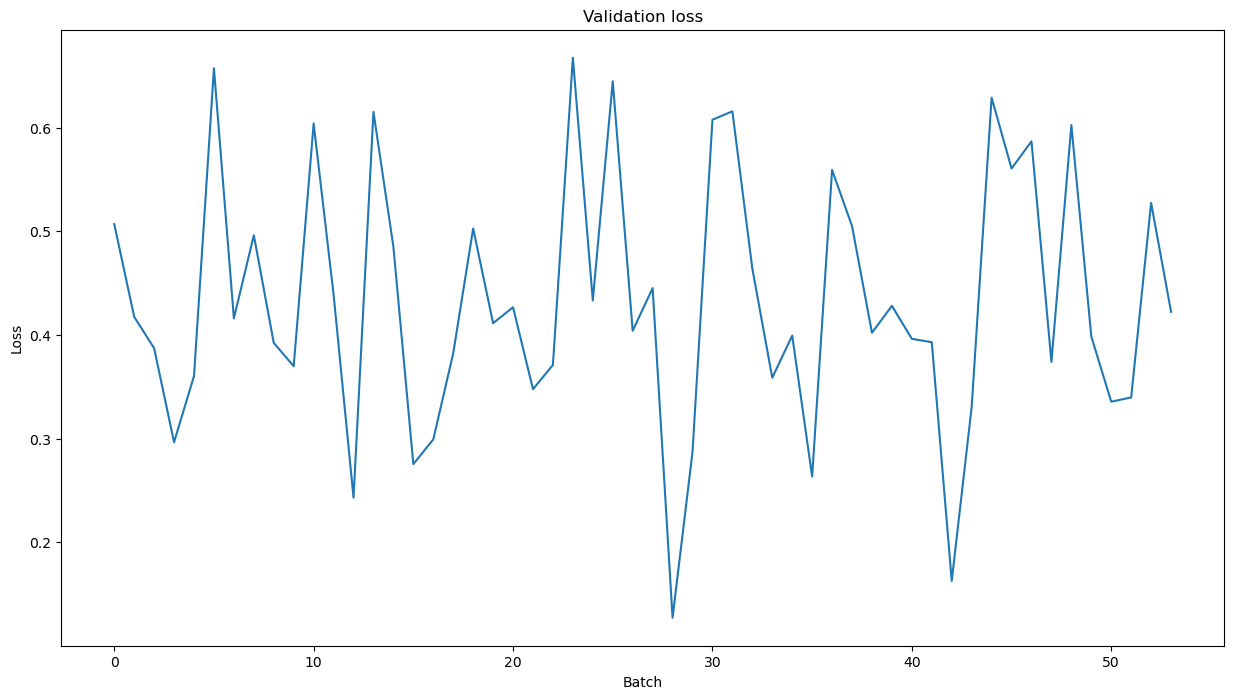

In [51]:
# Visualize validation loss.
plt.figure(figsize=(15,8))
plt.title("Validation loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(loss_val_list)
plt.show()


In [52]:
# Prepare test data for model.
data_test = pd.read_csv(
    os.path.join(data_dir, 'out_of_domain_dev.tsv'),
    names=['source', 'label', 'notes', 'sentence'],
    delimiter='\t',
    header=None
)

sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in data_test['sentence'].values]
labels_test = data_test['label'].values
tokenized_sentences_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]

unpadded_sentence_ids_test = [tokenizer.convert_tokens_to_ids(s) for s in tokenized_sentences_test]
sentence_ids_test = np.array([np.pad(np.array(x).flatten(),
                    pad_width =(0, MAX_LEN-len(x)),
                    mode='constant',
                    constant_values=0.
                ) for x in unpadded_sentence_ids_test])
attention_masks_test = np.array([
    np.concatenate(
        [np.ones(shape=(len(x))), np.zeros(shape=(MAX_LEN - len(x)))]
    ) for x in unpadded_sentence_ids_test
])

test_sequences = torch.tensor(sentence_ids_test)
test_masks = torch.tensor(attention_masks_test)
test_labels = torch.tensor(labels_test)

dataset_test = TensorDataset(test_sequences, test_masks, test_labels)
test_sampler = SequentialSampler(dataset_test)
test_loader = DataLoader(dataset_test, sampler=test_sampler, batch_size=BATCH_SIZE)


In [53]:
# Make predictions on the test set.
model.eval()

preds = []
true_state = []

for test_step, batch in tqdm(enumerate(test_loader)):
    batch_sequences = batch[0].long().to(DEVICE)
    batch_masks = batch[1].long().to(DEVICE)
    batch_labels = batch[2].long().to(DEVICE)
    
    # TODO: Remove. Only for debugging. 
    if MAX_BATCHES:
        if test_step == MAX_BATCHES:
            break
    
    with torch.no_grad():
        output = model(batch_sequences, token_type_ids=None, attention_mask=batch_masks)
    
    logits = output['logits'].detach().cpu().numpy()
    np_labels = batch_labels.to('cpu').numpy()
    preds.append(logits)
    true_state.append(np_labels)


17it [00:14,  1.17it/s]


In [54]:
# Evaluate performance on the test set using aggregate Matthew's evaluation.
flattened_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flattened_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_state for item in sublist]

matthews_corrcoef(flat_true_labels, flat_predictions)

0.4437444256817288